# June 22, 2025: quantify multiplicity
using plots of $\omega$'s

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
import random
import re

from sklearn.utils import resample

# import arviz as az

import ants
import nibabel as nib

from itertools import product, combinations, chain
import multiprocessing as mp
from functools import partial
from multiprocessing import Process

# networks
import graph_tool.all as gt


# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from matplotlib.colors import Normalize

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT
import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [5]:
args.source ='allen' #'spatial' #'allen'
args.space = 'ccfv2' #'yale' #'ccfv2'
args.brain_div = 'whl' #'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [6]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [7]:
args.dc, args.sbm = False, 'h'

args.nested = True if args.sbm in ['h'] else False

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['m', 'a'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [8]:
marginals_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl', recursive=True))
marginals_df = []
for sbm_file in marginals_files:
    with open(f'{sbm_file}', 'rb') as f:
        row = pickle.load(f)
    marginals_df += [row]
marginals_df = pd.concat(marginals_df).reset_index(drop=True)
mode_ids = list(chain.from_iterable([list(range(count)) for count in marginals_df['sub'].value_counts().sort_index().to_list()]))
marginals_df['mode_id'] = mode_ids
marginals_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned,omega,mode_id
0,SLC01,sbm-nd-h,"[[0.9943502824858758, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9082639088384565, 0.005617798206134892, 0....","[[0.8850912125784436, 0.09756830776993501, 0.0...","[[0.9881457547053836, 0.011854245294616511], [...","[[0.9952583018821535, 0.004741698117846605], [...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[0.9976291509410767, 0.0023708490589233024], ...","[[1.0], [1.0], [1.0000000000000002], [1.0], [0...",0.177295,0
1,SLC01,sbm-nd-h,"[[0.9924242424242424, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9305555555555556, 0.0, 0.00751836547291092...","[[0.8583704854173055, 0.11905640763280642, 0.0...","[[0.9686317578785476, 0.03136824212145242], [0...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.132086,1
2,SLC01,sbm-nd-h,"[[0.9672131147540983, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9002956194571352, 0.0, 0.00792797635044343...","[[0.8373335842458809, 0.11451218593710696, 0.0...","[[0.9879460856908309, 0.012053914309169156], [...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...","[[1.0], [0.9999999999999999], [0.9999999999999...",0.122464,2
3,SLC01,sbm-nd-h,"[[0.989247311827957, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.9813851312290439, 0.0, 0.00011562030292519...","[[0.9137888107775382, 0.06490505861861601, 0.0...","[[0.9885271006993847, 0.011472899300615397], [...","[[0.997705420139877, 0.0022945798601230792], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",0.093199,3
4,SLC01,sbm-nd-h,"[[0.44565217391304346, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.9117334697438667, 0.028759166164648204, 0....","[[0.9033271327908874, 0.095322184980498, 0.000...","[[0.9909216966685239, 0.009078303331476], [0.9...","[[0.995460848334262, 0.004539151665738], [0.99...","[[0.995460848334262, 0.004539151665738], [0.99...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...","[[1.0], [1.0000000000000002], [1.0], [1.000000...",0.091858,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.02105398883751773, 0.00040523863029342963,...","[[0.9629751425533718, 0.0367510004382298, 0.00...","[[0.9914532557120393, 0.008546744287960418], [...","[[0.9982906511424077, 0.0017093488575920836], ...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...","[[0.9999999999999998], [1.0], [1.0], [1.0], [1...",0.233420,1
81,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.9869606077218264,...","[[0.9629514024881322, 0.037048597511867884, 0....","[[0.9919459570626374, 0.008054042937362584], [...","[[0.9991945957062638, 0.0008054042937362584], ...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...","[[1.0], [1.0], [1.0], [1.0], [1.0], [0.9999999...",0.226136,2
82,SLC10,sbm-nd-h,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.014634146341463415, 0.0, 0.0, 0.0, 0.0, 0....","[[0.9943370542744164, 0.0054487874864401434, 0...","[[0.9995046556830509, 0.000495344316949104], [...","[[0.9997523278415255, 0.000247672158474552], [...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",

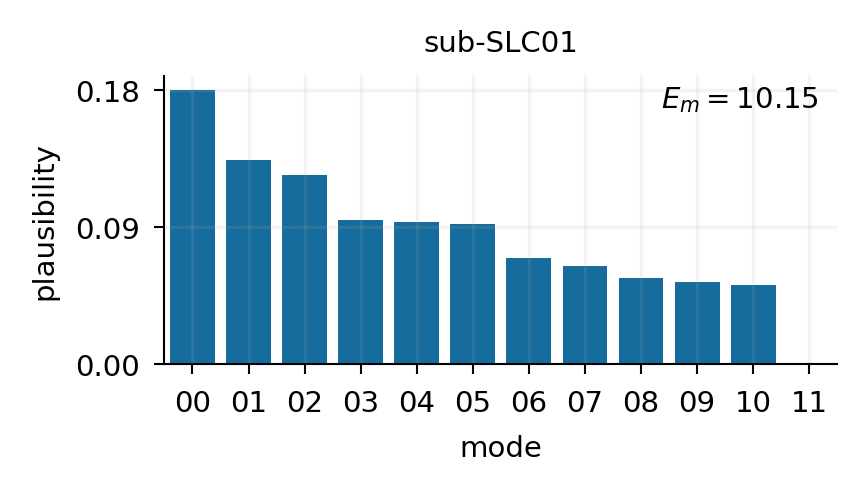

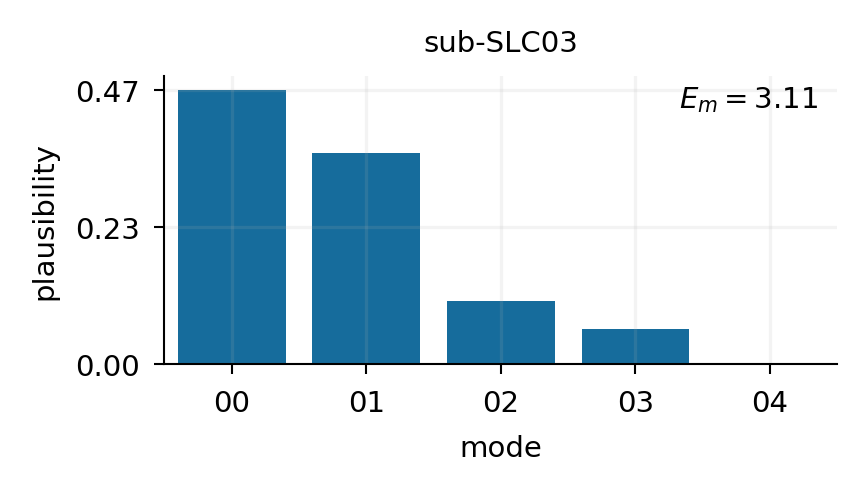

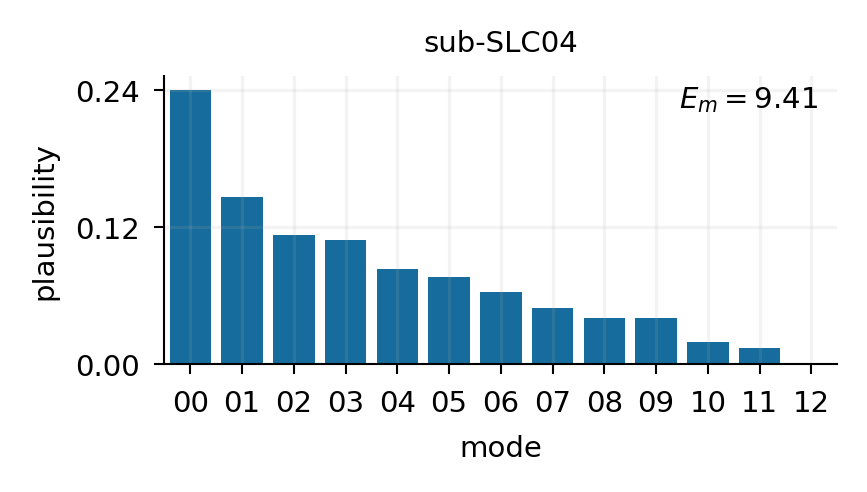

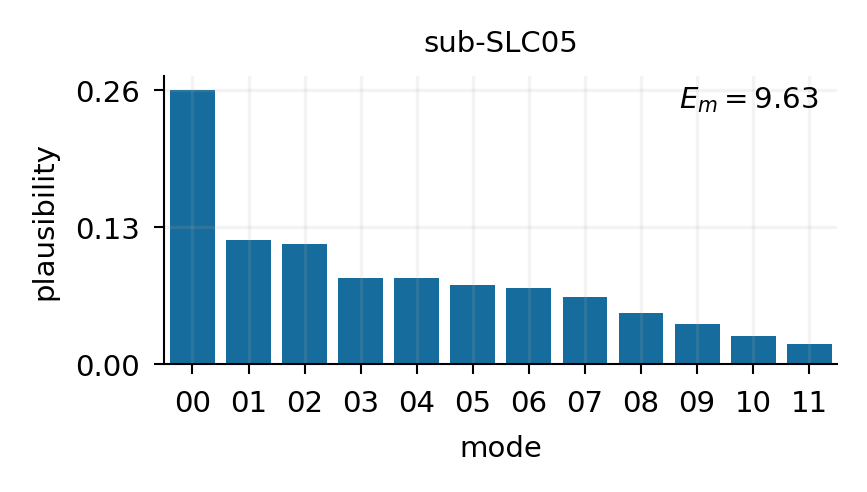

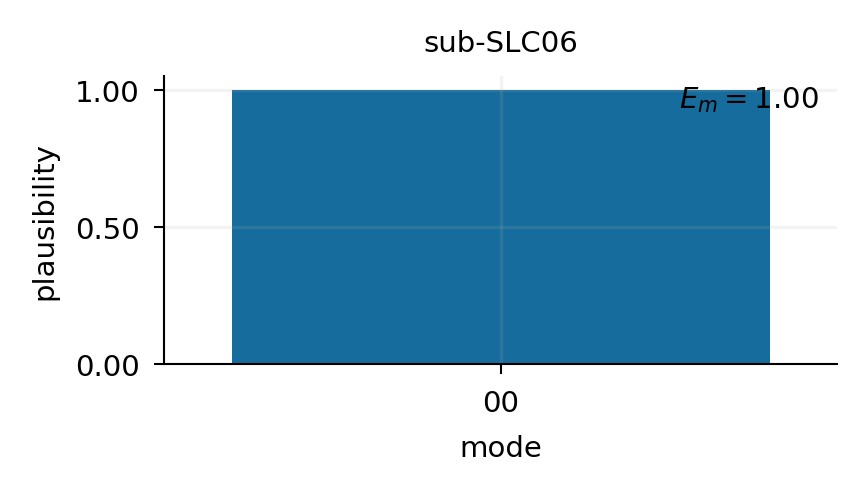

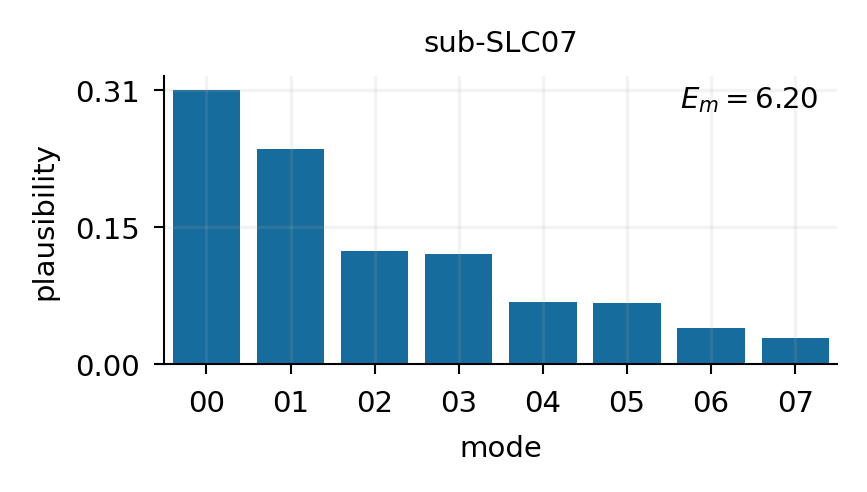

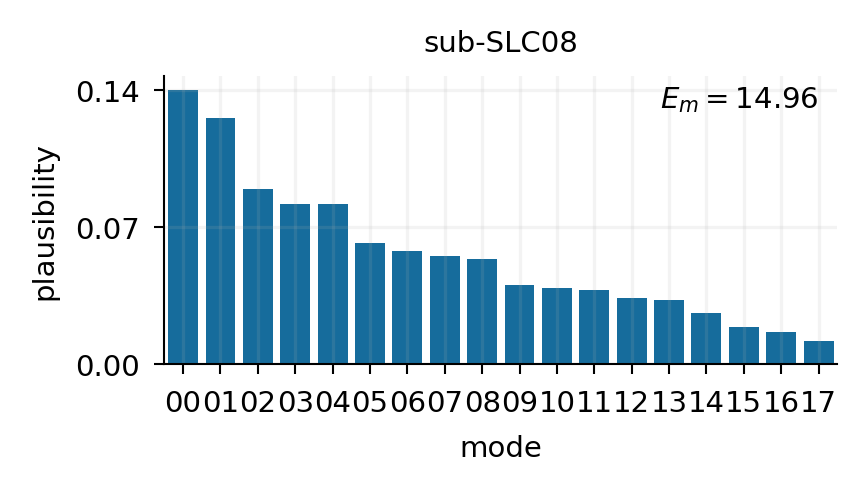

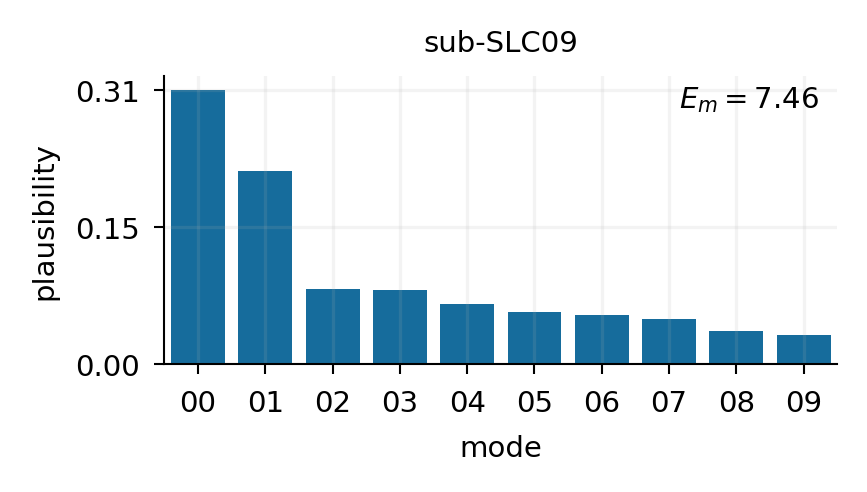

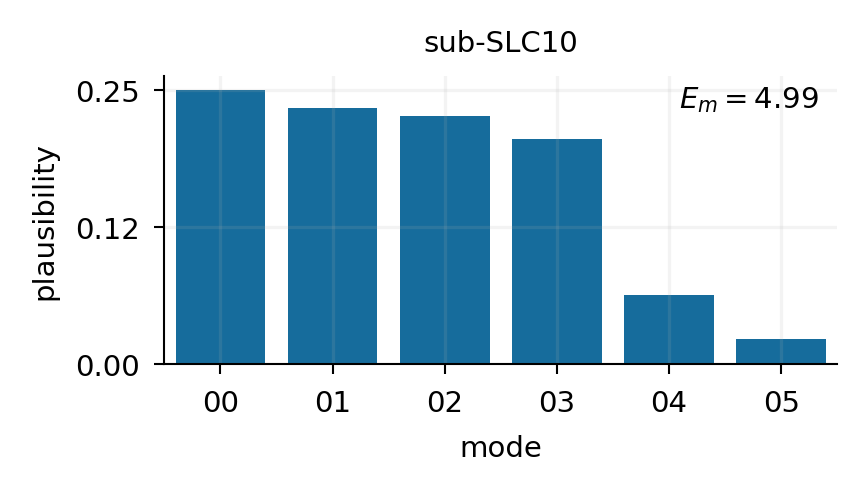

In [9]:
width = 200 #100
height = 100 #150
for sub, group in marginals_df.groupby('sub'):
    # if not sub == 'SLC03': continue
    fig, axs = plt.subplots(1, 1, figsize=(width/72.27, height/72.27))
    ax = axs
    plt.tight_layout()
    sns.barplot(
        group, 
        ax=ax,
        x='mode_id',
        y='omega',
        orient='v',
    )
    ax.grid(alpha=0.15)
    ax.set(xlabel=f'mode', ylabel=f'plausibility', title=f'sub-{sub}')
    ax.set_xticklabels([f'{mode_id:02d}' for mode_id in group['mode_id']])
    max_val = group['omega'].max()
    yticks = np.linspace(0, max_val, 3)
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{y:.2f}" for y in yticks])
    
    
    omegas = np.array(group['omega'].to_list())
    E_m = np.exp(-np.sum(omegas * np.log(omegas)))
    pad_pts = 2
    pad_rel = pad_pts / 72.27  # convert points to inches, relative to axes
    ax.text(
        1-pad_rel, 1-pad_rel, 
        rf'$E_m = {E_m:.2f}$',
        ha='right', va='top',
        transform=ax.transAxes,
        color='black'
    )
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    folder = (
        f'{ESTIM_path}/individual/sub-{sub}/partition-modes-group-aligned/{SBM}'
    )
    os.makedirs(folder, exist_ok=True)
    fig.savefig(f'{folder}/desc-omega-barplot.svg', bbox_inches='tight', transparent=True)
    # break